In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
from os import listdir
from os.path import isfile, join

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import OPTICS
from sklearn.mixture import BayesianGaussianMixture 

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape, Dense, BatchNormalization
from tensorflow.keras.layers import Activation, LeakyReLU

import keras_radam
from keras_radam import RAdam
from tensorflow.keras.utils import plot_model

import numpy as np
import joblib 
import matplotlib.pyplot as plt

from CRISMrelatedMethods.preprocessing import *
from CRISMrelatedMethods.dataRead import *

## Augmented Data

In [2]:
spectralLibPath='../../spectralLibrary/'
Wstart,Wend=1.05,2.6
spectralWavelength,spectralIF,spectralFiles,mineralNames,spectralWavelengthSet=readSpectralLib(spectralLibPath,startW=Wstart,endW=Wend)

In [3]:
plebaniMICAclass={1:6, 2:12, 3:11, 4:16, 6:10, 7:24, 8:28, 9:18, 10:29, 11:0, 13:8, 18:1, 15:19, 17:7, 23:17, 25:2, 26:25, 27:15, 30:22, 31:5, 33:20, 35:13, 36:9, 37:4} #, 5:14, 19:27, 34:23, 16:3
plebaniMICAclass_rev={plebaniMICAclass[p]:p for p in plebaniMICAclass}

mineralGroupNames=['Iron oxides and primary silicates','Ices','Sulfates','Phyllosilicates','Carbonates','Hydrated silicates and halides']
mineralGroupList=[[14,23,9,26,20,13],[6,12],[0,27,25,3,18,11,16],[19,1,21,17,10,24,30,29,5],[8,22],[28,7,15,2,4]]
mineralGroupDict={g:G for G in range(len(mineralGroupList)) for g in mineralGroupList[G] }

In [51]:
perMineralAug=1000

X,y=[],[]
shiftAug=0
mineralCount=-1
mineralIndexMap={}
originalSpectraList=[]
for file_index in range(len(spectralFiles)):
    if plebaniMICAclass_rev.get(file_index) is None: continue
    mineralCount+=1
    mineralIndexMap[mineralCount]=file_index
    interpFunc=interp1d(spectralWavelength[file_index],spectralIF[file_index], kind='linear')
    originalSpectra=interpFunc(spectralWavelengthSet)
    originalSpectraList.append(originalSpectra)
    for i in range(perMineralAug):
        noisedSpectra=getContiNoised(getShiftNoised(originalSpectra,maxprcn=60),noiseStd=0.0075*(i%11),targetWL=spectralWavelengthSet)
        X.append(noisedSpectra)
        y.append(mineralCount)  
X=np.array(X)
y=np.array(y) 

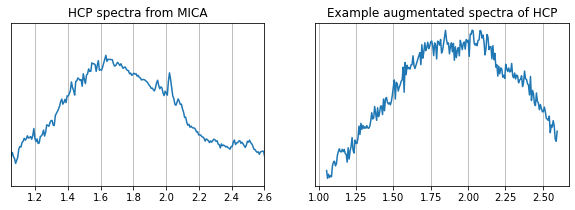

In [125]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(spectralWavelength[13],spectralIF[13])
plt.xlim(Wstart,Wend)
plt.ylim(.17,.2)
plt.yticks([])
plt.grid()
plt.title('HCP spectra from MICA')
plt.subplot(1,2,2)
plt.plot(spectralWavelengthSet,X[13*1000+25])
plt.yticks([])
plt.grid()
plt.title('Example augmentated spectra of HCP')
plt.show()

## Labelled Test Data

Downloaded from https://cs.iupui.edu/~mdundar/CRISM.htm (‘Ratioed training dataset for mineral classes’)

In [55]:
plebaniMICA_X,plebaniMICA_Y=getPlebaniData('../../CRISM_labeled_pixels_ratioed',plebaniMICAclass,spectralWavelengthSet,perLabelData=1000)  # 100 spectra per class

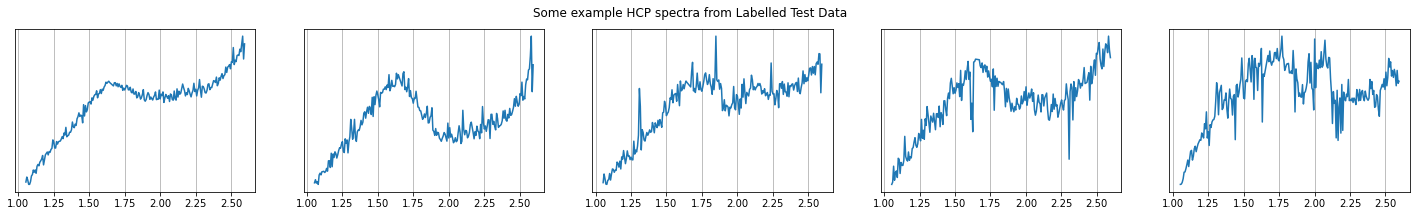

In [68]:
plt.figure(figsize=(5*5,3))
plt.suptitle('Some example HCP spectra from Labelled Test Data')
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(spectralWavelengthSet,plebaniMICA_X[19000+i])
    plt.yticks([])
    plt.grid()
plt.show()

## Pre-processing

smoothing

In [57]:
plebaniMICA_X_sm=getSmoothedData(plebaniMICA_X)
X_sm=getSmoothedData(X)

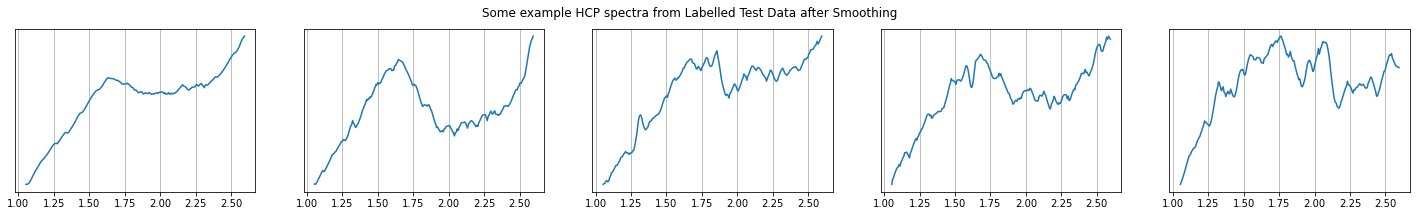

In [69]:
plt.figure(figsize=(5*5,3))
plt.suptitle('Some example HCP spectra from Labelled Test Data after Smoothing')
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(spectralWavelengthSet,plebaniMICA_X_sm[19000+i])
    plt.yticks([])
    plt.grid()
plt.show()

continuum removal

In [70]:
plebaniMICA_X_smCR=getContinuumRemovedData(plebaniMICA_X_sm)
X_smCR=getContinuumRemovedData(X_sm)

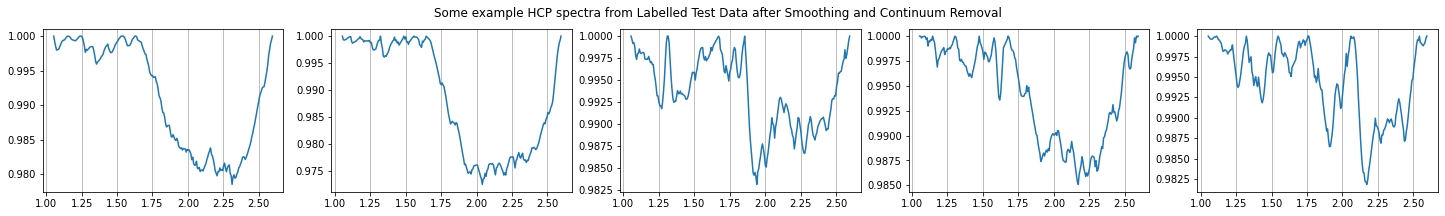

In [72]:
plt.figure(figsize=(5*5,3))
plt.suptitle('Some example HCP spectra from Labelled Test Data after Smoothing and Continuum Removal')
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(spectralWavelengthSet,plebaniMICA_X_smCR[19000+i])
    plt.gca().xaxis.grid(True)
plt.show()

standard scaler

In [73]:
plebaniMICA_X_smCRSS=getStandardScaledData(plebaniMICA_X_smCR)
X_smCRSS=getStandardScaledData(X_smCR)

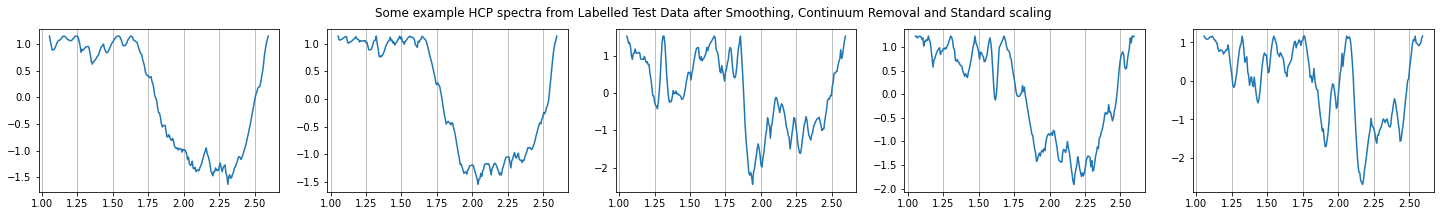

In [74]:
plt.figure(figsize=(5*5,3))
plt.suptitle('Some example HCP spectra from Labelled Test Data after Smoothing, Continuum Removal and Standard scaling')
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(spectralWavelengthSet,plebaniMICA_X_smCRSS[19000+i])
    plt.gca().xaxis.grid(True)
plt.show()

Absorption Feature Extraction

In [75]:
P=getDiversePositions(spectralIF,spectralWavelength,spectralWavelengthSet)
X_smCRSSFE=getFeatureData(X_smCRSS,P)
plebaniMICA_X_smCRSSFE=getFeatureData(plebaniMICA_X_smCRSS,P)

## Models

In [76]:
def getLabelPairing(c_labels,y_labels):
    cUnique=list(np.unique(c_labels))
    cSlices=[np.where(c_labels==i,True,False) for i in cUnique]
    yUnique=list(np.unique(y_labels))
    ySlices=[np.where(y_labels==i,True,False) for i in yUnique]

    matchMat=np.zeros((len(cUnique),len(yUnique)))
    for c in range(len(cSlices)):
        for yy in range(len(ySlices)):
            matchMat[c,yy]=np.sum(cSlices[c]&ySlices[yy])/np.sum(cSlices[c]|ySlices[yy])
            
    S=(np.dstack(np.unravel_index(np.argsort(-matchMat.ravel()), (len(cUnique),len(yUnique)))))[0]
    matched_yc,matched_cy={},{}
    for s in S:
        if matched_yc.get(yUnique[s[1]]) is None and matched_cy.get(cUnique[s[0]]) is None:
            matched_yc[yUnique[s[1]]]=cUnique[s[0]]
            matched_cy[cUnique[s[0]]]= yUnique[s[1]]
    return matched_cy

def getGroupPred(pred):        
    return np.array([mineralGroupDict[p] for p in pred])

def getClassWiseAccuracy(c_labels,y_labels):
    cSlices={i:np.where(c_labels==i,True,False) for i in np.unique(c_labels)}
    ySlices={i:np.where(y_labels==i,True,False) for i in np.unique(y_labels)}
    return {i:np.sum(cSlices[i]&ySlices[i])/np.sum(ySlices[i]) for i in cSlices}

def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

--------------------------------------------------------------------
Artificial Neural Network (ANN)

In [77]:
plebaniMICA_X_smCRSSFE_copy,plebaniMICA_Y_copy=np.copy(plebaniMICA_X_smCRSSFE),np.copy(plebaniMICA_Y)
plebaniMICA_X_smCRSSFE_copy,plebaniMICA_Y_copy=shuffle_in_unison(plebaniMICA_X_smCRSSFE_copy,plebaniMICA_Y_copy)

X_smCRSSFE_copy,Y_copy=np.copy(X_smCRSSFE),np.copy(y.ravel())
X_smCRSSFE_copy,Y_copy=shuffle_in_unison(X_smCRSSFE_copy,Y_copy)

noOfFolds=5

individual_mineral,mineral_group,groupwisePerf=[],[],{i:[] for i in range(len(mineralGroupNames))}
for f in range(noOfFolds):
    testX=plebaniMICA_X_smCRSSFE_copy[(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*f:(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*(f+1),:]
    testY=plebaniMICA_Y_copy[(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*f:(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*(f+1)]
    
    trainingData=X_smCRSSFE_copy

    tf.keras.backend.clear_session()
    trainingData_rs = trainingData.reshape(trainingData.shape[0],trainingData.shape[1])
    X_train,X_test,y_train,y_test = train_test_split(trainingData_rs,Y_copy,test_size=0.25,random_state=20)
    newYTrain = to_categorical(y_train)
    newYTest = to_categorical(y_test)

    model = Sequential()
    model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(newYTrain.shape[1], activation='softmax'))

    loss='categorical_crossentropy'
    optimizer = RAdam(total_steps=5000, warmup_proportion=0.1, min_lr=1e-5)
    metrics=['accuracy']
    model.compile(loss=loss, optimizer=optimizer , metrics=metrics)

    totalEpochs=0
    batch_size=240
    epochs=50
    totalEpochs+=epochs      
    fitHistory = model.fit(X_train, newYTrain, validation_data=(X_test, newYTest), epochs=epochs,batch_size = batch_size, verbose=0)   

    Ppredict=(model.predict(testX))
    Plabel=np.array([mineralIndexMap[np.argmax(Ppredict[p])] for p in range(Ppredict.shape[0])])
    
    
    individual_mineral.append(np.sum(np.where(Plabel==testY,True,False))/testY.shape[0])
    mineral_group.append(np.sum(np.where(getGroupPred(Plabel)==getGroupPred(testY),True,False))/testY.shape[0])
    
    G=getClassWiseAccuracy(getGroupPred(Plabel),getGroupPred(testY))
    for g in G:
        groupwisePerf[g].append(G[g])
    
print('mineral_group',np.round(np.mean(mineral_group),4),np.round(np.std(mineral_group),3))
print('groupwisePerf',[(mineralGroupNames[g],np.round(np.mean(groupwisePerf[g]),4),np.round(np.std(groupwisePerf[g]),3)) for g in groupwisePerf])

mineral_group 0.8228 0.014
groupwisePerf [('Iron oxides and primary silicates', 0.9509, 0.006), ('Ices', 0.8396, 0.035), ('Sulfates', 0.8374, 0.011), ('Phyllosilicates', 0.8126, 0.039), ('Carbonates', 0.6229, 0.051), ('Hydrated silicates and halides', 0.819, 0.013)]


In [83]:
print("predicted labels for example 'hcp' class: ",[mineralNames[p] for p in (np.argmax(model.predict(plebaniMICA_X_smCRSSFE[19000:19005,:]),axis=1))])

predicted labels for example 'hcp' class:  ['hcp', 'hcp', 'hcp', 'hcp', 'hcp']


---------------------------------------------------------------------------------------------------------------------
Random Forest Classifier (RFC)

In [90]:
plebaniMICA_X_smCRSSFE_copy,plebaniMICA_Y_copy=np.copy(plebaniMICA_X_smCRSSFE),np.copy(plebaniMICA_Y)
plebaniMICA_X_smCRSSFE_copy,plebaniMICA_Y_copy=shuffle_in_unison(plebaniMICA_X_smCRSSFE_copy,plebaniMICA_Y_copy)

X_smCRSSFE_copy,Y_copy=np.copy(X_smCRSSFE),np.copy(y.ravel())
X_smCRSSFE_copy,Y_copy=shuffle_in_unison(X_smCRSSFE_copy,Y_copy)

noOfFolds=4

individual_mineral,mineral_group,groupwisePerf=[],[],{i:[] for i in range(len(mineralGroupNames))}
for f in range(noOfFolds):
    testX=plebaniMICA_X_smCRSSFE_copy[(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*f:(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*(f+1),:]
    testY=plebaniMICA_Y_copy[(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*f:(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*(f+1)]
    
    rfc=RandomForestClassifier(n_estimators=100, bootstrap=True, warm_start=True).fit(X_smCRSSFE_copy,Y_copy)

    y_=rfc.predict(testX)
    c_label=np.array([mineralIndexMap[y_[p]] for p in range(y_.shape[0])])
    
    individual_mineral.append(np.sum(np.where(c_label==testY,True,False))/testY.shape[0])
    mineral_group.append(np.sum(np.where(getGroupPred(c_label)==getGroupPred(testY),True,False))/testY.shape[0])
    
    G=getClassWiseAccuracy(getGroupPred(c_label),getGroupPred(testY))
    for g in G:
        groupwisePerf[g].append(G[g])
    
print('mineral_group',np.round(np.mean(mineral_group),4),np.round(np.std(mineral_group),3))
print('groupwisePerf',[(mineralGroupNames[g],np.round(np.mean(groupwisePerf[g]),4),np.round(np.std(groupwisePerf[g]),3)) for g in groupwisePerf])

mineral_group 0.8107 0.006
groupwisePerf [('Iron oxides and primary silicates', 0.9588, 0.005), ('Ices', 0.8552, 0.023), ('Sulfates', 0.8397, 0.004), ('Phyllosilicates', 0.7829, 0.01), ('Carbonates', 0.6978, 0.039), ('Hydrated silicates and halides', 0.7594, 0.012)]


In [105]:
print("predicted labels for example 'hcp' class: ",[mineralNames[p] for p in rfc.predict(plebaniMICA_X_smCRSSFE[19000:19005,:])])

predicted labels for example 'hcp' class:  ['hcp', 'hcp', 'hcp', 'hcp', 'hcp']


-----------------------------------------------------------------------------------------
Support Vector Classifier (SVC)

In [110]:
plebaniMICA_X_smCRSSFE_copy,plebaniMICA_Y_copy=np.copy(plebaniMICA_X_smCRSSFE),np.copy(plebaniMICA_Y)
plebaniMICA_X_smCRSSFE_copy,plebaniMICA_Y_copy=shuffle_in_unison(plebaniMICA_X_smCRSSFE_copy,plebaniMICA_Y_copy)

X_smCRSSFE_copy,Y_copy=np.copy(X_smCRSSFE),np.copy(y.ravel())
X_smCRSSFE_copy,Y_copy=shuffle_in_unison(X_smCRSSFE_copy,Y_copy)

noOfFolds=4
    
pca=PCA(.95)
pca.fit(X_smCRSSFE)

individual_mineral,mineral_group,groupwisePerf=[],[],{i:[] for i in range(len(mineralGroupNames))}
for f in range(noOfFolds):
    testX=plebaniMICA_X_smCRSSFE_copy[(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*f:(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*(f+1),:]
    testY=plebaniMICA_Y_copy[(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*f:(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*(f+1)]

    svc=SVC(tol=1e-3, kernel='rbf',gamma='scale',C=1).fit(pca.transform(X_smCRSSFE_copy),Y_copy)

    y_=svc.predict(pca.transform(testX))
    c_label=np.array([mineralIndexMap[y_[p]] for p in range(y_.shape[0])])
    
    individual_mineral.append(np.sum(np.where(c_label==testY,True,False))/testY.shape[0])
    mineral_group.append(np.sum(np.where(getGroupPred(c_label)==getGroupPred(testY),True,False))/testY.shape[0])
    
    G=getClassWiseAccuracy(getGroupPred(c_label),getGroupPred(testY))
    for g in G:
        groupwisePerf[g].append(G[g])
    
print('mineral_group',np.round(np.mean(mineral_group),4),np.round(np.std(mineral_group),3))
print('groupwisePerf',[(mineralGroupNames[g],np.round(np.mean(groupwisePerf[g]),4),np.round(np.std(groupwisePerf[g]),3)) for g in groupwisePerf])

mineral_group 0.8151 0.005
groupwisePerf [('Iron oxides and primary silicates', 0.9467, 0.01), ('Ices', 0.8794, 0.013), ('Sulfates', 0.8301, 0.007), ('Phyllosilicates', 0.8176, 0.001), ('Carbonates', 0.6262, 0.019), ('Hydrated silicates and halides', 0.7671, 0.009)]


In [97]:
print("predicted labels for example 'hcp' class: ",[mineralNames[p] for p in svc.predict(pca.transform(plebaniMICA_X_smCRSSFE[19000:19005,:]))])

predicted labels for example 'hcp' class:  ['hcp', 'hcp', 'hcp', 'hcp', 'hcp']


--------------------------------------------------------
Ordering Points To Identify Clustering Structure (OPTICS)

In [92]:
plebaniMICA_X_smCRSS_copy,plebaniMICA_Y_copy=np.copy(plebaniMICA_X_smCRSS),np.copy(plebaniMICA_Y)
plebaniMICA_X_smCRSS_copy,plebaniMICA_Y_copy=shuffle_in_unison(plebaniMICA_X_smCRSS_copy,plebaniMICA_Y_copy)
noOfFolds=8
individual_mineral,mineral_group,groupwisePerf=[],[],{i:[] for i in range(len(mineralGroupNames))}
for f in range(noOfFolds):
    testX=plebaniMICA_X_smCRSS_copy[(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*f:(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*(f+1),:]
    testY=plebaniMICA_Y_copy[(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*f:(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*(f+1)]

    clustering = OPTICS(min_samples=.01, algorithm='brute',xi=.001,metric='correlation',min_cluster_size=.01).fit(testX)
    labels=clustering.labels_

    labels-=np.min(labels)
    labelPairing= getLabelPairing(labels, testY)
    c_label=np.array([labelPairing[labels[l]] for l in range(labels.shape[0])])
    
    individual_mineral.append(np.sum(np.where(c_label==testY,True,False))/testY.shape[0])
    mineral_group.append(np.sum(np.where(getGroupPred(c_label)==getGroupPred(testY),True,False))/testY.shape[0])
    
    G=getClassWiseAccuracy(getGroupPred(c_label),getGroupPred(testY))
    for g in G:
        groupwisePerf[g].append(G[g])
    
print('mineral_group',np.round(np.mean(mineral_group),4),np.round(np.std(mineral_group),3))
print('groupwisePerf',[(mineralGroupNames[g],np.round(np.mean(groupwisePerf[g]),4),np.round(np.std(groupwisePerf[g]),3)) for g in groupwisePerf])

mineral_group 0.6721 0.054
groupwisePerf [('Iron oxides and primary silicates', 0.8585, 0.066), ('Ices', 0.8667, 0.032), ('Sulfates', 0.6758, 0.12), ('Phyllosilicates', 0.7223, 0.321), ('Carbonates', 0.1975, 0.044), ('Hydrated silicates and halides', 0.6177, 0.22)]


In [118]:
clustering = OPTICS(min_samples=.01, algorithm='brute',xi=.001,metric='correlation',min_cluster_size=.01).fit(plebaniMICA_X_smCRSS)
labels=clustering.labels_

labels-=np.min(labels)
labelPairing= getLabelPairing(labels, plebaniMICA_Y)
c_label=np.array([labelPairing[labels[l]] for l in range(labels.shape[0])])

print("predicted labels for example 'hcp' class: ",[mineralNames[p] for p in c_label[19000:19005]])

predicted labels for example 'hcp' class:  ['hcp', 'hcp', 'serpentine', 'hcp', 'serpentine']


----------------------------------------------------------------
linear discriminant analysis (LDA)

In [94]:
plebaniMICA_X_smCRSS_copy,plebaniMICA_Y_copy=np.copy(plebaniMICA_X_smCRSS),np.copy(plebaniMICA_Y)
plebaniMICA_X_smCRSS_copy,plebaniMICA_Y_copy=shuffle_in_unison(plebaniMICA_X_smCRSS_copy,plebaniMICA_Y_copy)
noOfFolds=8
individual_mineral,mineral_group,groupwisePerf=[],[],{i:[] for i in range(len(mineralGroupNames))}
for f in range(noOfFolds):
    testX=plebaniMICA_X_smCRSS_copy[(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*f:(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*(f+1),:]
    testY=plebaniMICA_Y_copy[(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*f:(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*(f+1)]

    X_train,X_test,y_train,y_test = train_test_split(testX,testY,test_size=0.3,random_state=20)
    lda = LDA(shrinkage=1,solver='lsqr').fit(X_train, y_train)

    y_=lda.predict(X_test)
    
    individual_mineral.append(np.sum(np.where(y_==y_test,True,False))/y_test.shape[0])
    mineral_group.append(np.sum(np.where(getGroupPred(y_)==getGroupPred(y_test),True,False))/y_test.shape[0])
    
    G=getClassWiseAccuracy(getGroupPred(y_),getGroupPred(y_test))
    for g in G:
        groupwisePerf[g].append(G[g])
    
# print('individual_mineral',np.round(np.mean(individual_mineral),4),np.round(np.std(individual_mineral),3))
print('mineral_group',np.round(np.mean(mineral_group),4),np.round(np.std(mineral_group),3))
print('groupwisePerf',[(mineralGroupNames[g],np.round(np.mean(groupwisePerf[g]),4),np.round(np.std(groupwisePerf[g]),3)) for g in groupwisePerf])

mineral_group 0.8438 0.014
groupwisePerf [('Iron oxides and primary silicates', 0.9664, 0.016), ('Ices', 0.9235, 0.035), ('Sulfates', 0.8776, 0.031), ('Phyllosilicates', 0.8217, 0.024), ('Carbonates', 0.6217, 0.065), ('Hydrated silicates and halides', 0.8269, 0.024)]


In [99]:
print("predicted labels for example 'hcp' class: ",[mineralNames[p] for p in lda.predict(plebaniMICA_X_smCRSS[19000:19005])])

predicted labels for example 'hcp' class:  ['hcp', 'hcp', 'hcp', 'hcp', 'hcp']


----------------------------------------------------
Bayesian Gaussian Dirichlet Process Mixture (DPM)

In [100]:
plebaniMICA_X_smCRSS_copy,plebaniMICA_Y_copy=np.copy(plebaniMICA_X_smCRSS),np.copy(plebaniMICA_Y)
plebaniMICA_X_smCRSS_copy,plebaniMICA_Y_copy=shuffle_in_unison(plebaniMICA_X_smCRSS_copy,plebaniMICA_Y_copy)
noOfFolds=10
individual_mineral,mineral_group,groupwisePerf=[],[],{i:[] for i in range(len(mineralGroupNames))}
for f in range(noOfFolds):
    testX=plebaniMICA_X_smCRSS_copy[(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*f:(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*(f+1),:]
    testY=plebaniMICA_Y_copy[(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*f:(int(plebaniMICA_Y_copy.shape[0]/noOfFolds))*(f+1)]
    
    pca=PCA(.95)
    pca.fit(testX)

    X_train,X_test,y_train,y_test = train_test_split(testX,testY,test_size=0.2) #,random_state=20
    dpm = BayesianGaussianMixture(weight_concentration_prior_type='dirichlet_process',n_components=np.unique(y_train).shape[0], random_state=1,warm_start=True).fit(pca.transform(X_train), y_train)

    y_=dpm.predict(pca.transform(X_test))
    labelPairing= getLabelPairing(y_, y_test)
    c_label=np.array([labelPairing[y_[l]] for l in range(y_.shape[0])])

    individual_mineral.append(np.sum(np.where(c_label==y_test,True,False))/y_test.shape[0])
    mineral_group.append(np.sum(np.where(getGroupPred(c_label)==getGroupPred(y_test),True,False))/y_test.shape[0])
    
    G=getClassWiseAccuracy(getGroupPred(c_label),getGroupPred(y_test))
    for g in G:
        groupwisePerf[g].append(G[g])
    
print('mineral_group',np.round(np.mean(mineral_group),4),np.round(np.std(mineral_group),3))
print('groupwisePerf',[(mineralGroupNames[g],np.round(np.mean(groupwisePerf[g]),4),np.round(np.std(groupwisePerf[g]),3)) for g in groupwisePerf])

mineral_group 0.7621 0.032
groupwisePerf [('Iron oxides and primary silicates', 0.8813, 0.05), ('Ices', 0.7821, 0.108), ('Sulfates', 0.7948, 0.088), ('Phyllosilicates', 0.7262, 0.085), ('Carbonates', 0.5273, 0.218), ('Hydrated silicates and halides', 0.7955, 0.106)]


In [101]:
print("predicted labels for example 'hcp' class: ",[mineralNames[labelPairing[p]] for p in dpm.predict(pca.transform(plebaniMICA_X_smCRSS[19000:19005]))])

predicted labels for example 'hcp' class:  ['hcp', 'hcp', 'hcp', 'hcp', 'chloride']
